In [3]:
import pandas as pd
import numpy as np
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats


# UMAP

In [50]:
# Change data paths to your own
metadata = pd.read_csv("/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/Data/processed/processed_metadata.txt", sep="\t")
cluster_labels = pd.read_csv("/Users/harrisonma/Documents/PhD Classes/2025 Spring/BNFO 285/BNFO285_Projects/project_1/Harrison/dim_red/dtne_clustering_labels_df.tsv", sep="\t")

# Choose which method to use for clustering if you df has multiple clustering method labels
cluster_labels = cluster_labels.loc[:, ["sample_id", "kmeans_cluster_label"]]


In [51]:
# reomve metastatic samples
filtered_cluster_labels = cluster_labels[cluster_labels["sample_id"].apply(lambda x: not x.split('-')[3].startswith("06"))]

# Extract patient IDs
filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]
filtered_cluster_labels = filtered_cluster_labels.rename(columns={"kmeans_cluster_label": "cluster"})
df = pd.merge(filtered_cluster_labels, metadata, on='patient_id')
df = df.drop(columns=["sample_id"])


/var/folders/dr/_r18syxx1yd9jgt5prvtlwcr0000gn/T/ipykernel_4944/3662675582.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]


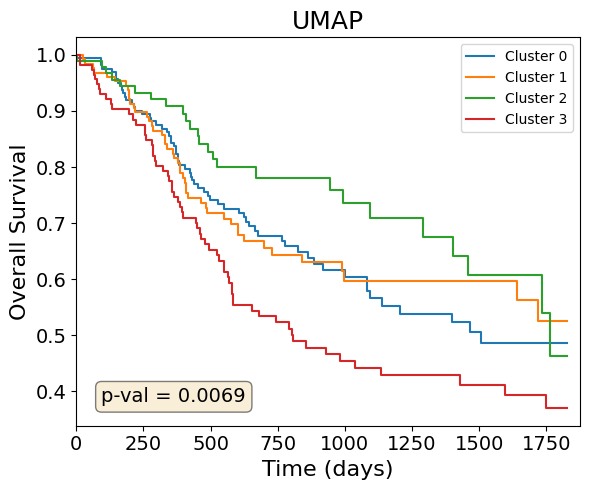

In [46]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import matplotlib.pyplot as plt
import numpy as np

kmf = KaplanMeierFitter()
plt.figure(figsize=(6, 5))

cutoff_days = 5 * 365
timeline = np.linspace(0, cutoff_days, 500)

for cluster, cluster_df in df.groupby('cluster'):
    kmf.fit(cluster_df['OS_time'], timeline=timeline, event_observed=cluster_df['OS'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False)

logrank_results = multivariate_logrank_test(df['OS_time'], df['cluster'], event_observed=df['OS'])

plt.title("UMAP", fontsize=18)
plt.xlabel("Time (days)", fontsize=16)
plt.ylabel("Overall Survival", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, cutoff_days + 50)

plt.legend(loc='upper right', fontsize=10, frameon=True)

ax = plt.gca()
ax.text(0.05, 0.05, f"p-val = {logrank_results.p_value:.4f}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()


   test_statistic         p  -log2(p)
0        5.457038  0.065316  3.936421


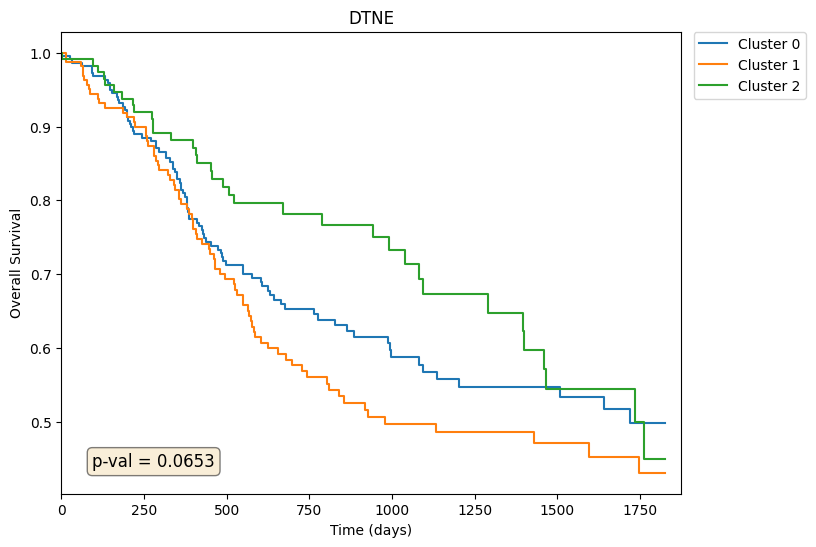

<lifelines.CoxPHFitter: fitted with 499 total observations, 283 right-censored observations>
             duration col = 'OS_time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 499
number of events observed = 216
   partial log-likelihood = -1173.38
         time fit was run = 2025-04-19 03:08:11 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1  0.19      1.21      0.15           -0.11            0.48                0.90                1.62
cluster_2 -0.27      0.77      0.19           -0.65            0.11                0.52                1.12

           cmp to     z    p  -log2(p)
covariate                             
cluster_1    0.00  1.25 0.21      2.24
cluster_2    0.00 -1.37 0.17      2.56
---
Concordance = 0.55
Partial AIC = 2350.75
log-likelihood ratio test = 5.58 on 2 df
-log2(p) of ll-ratio test = 4.02

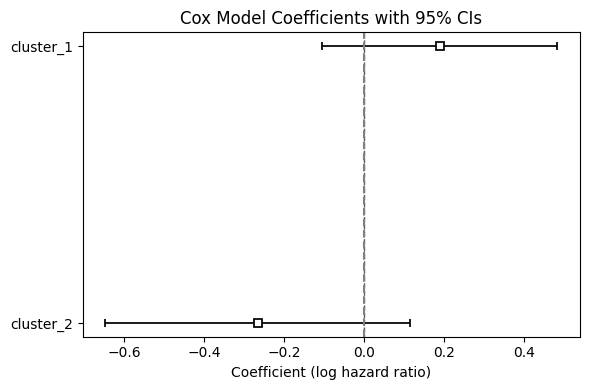

In [52]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization for OS
# -------------------------------------------------
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# define five-year cutoff in days
cutoff_days = 5 * 365
timeline = np.linspace(0, cutoff_days, 500)

# Loop through each cluster, fit, and plot the survival function
for cluster, cluster_df in df.groupby('cluster'):
    kmf.fit(cluster_df['OS_time'], timeline=timeline, event_observed=cluster_df['OS'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False)  # Plot survival function with confidence intervals

# -------------------------------------------------
# Multivariate Log-Rank Test for Comparing Survival Curves
# -------------------------------------------------
# The multivariate_logrank_test function compares the survival distribution
# across all groups at once.
logrank_results = multivariate_logrank_test(df['OS_time'], df['cluster'], event_observed=df['OS'])

print(logrank_results.summary)

plt.title("DTNE")
plt.xlim(0, cutoff_days+50)
plt.xlabel("Time (days)")
plt.ylabel("Overall Survival")
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)

ax = plt.gca()
ax.text(0.05, 0.05, f"p-val = {logrank_results.p_value:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
# Ensure the "cluster" column is treated as a categorical variable.
# Here we convert it to string and then create dummy variables.
df['cluster'] = df['cluster'].astype(str)
df_encoded = pd.get_dummies(df[['cluster']], drop_first=True)  # drop_first to set a reference level
df_model = pd.concat([df[['OS_time', 'OS']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, duration_col='OS_time', event_col='OS')
cph.print_summary()  # Displays hazard ratios, confidence intervals, and p-values

plt.figure(figsize=(6, 4))
cph.plot()
plt.title("Cox Model Coefficients with 95% CIs")
plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Coefficient (log hazard ratio)")
plt.tight_layout()
plt.show()


In [53]:
df


,cluster,patient_id,age,OS,OS_time,DSS,DSS_time,DFI,DFI_time,gender,tumor_site,tumor_class,tumor_stage
0,1,TCGA-4P-AA8J,66.0,0.0,102.0,0.0,102.0,NaN,NaN,MALE,tongue,primary,Stage IVA
1,1,TCGA-BA-4074,69.0,1.0,462.0,1.0,462.0,NaN,NaN,MALE,tongue,primary,Stage IVA
2,1,TCGA-BA-4075,49.0,1.0,283.0,1.0,283.0,NaN,NaN,MALE,tongue,primary,Stage III
3,0,TCGA-BA-4076,39.0,1.0,415.0,1.0,415.0,NaN,NaN,MALE,Larynx,primary,NaN
4,0,TCGA-BA-4077,45.0,1.0,1134.0,1.0,1134.0,NaN,NaN,FEMALE,tongue,primary,Stage IVA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0,TCGA-UF-A7JT,72.0,1.0,993.0,1.0,993.0,NaN,NaN,FEMALE,mouth,metastasis,NaN
495,0,TCGA-UF-A7JV,62.0,1.0,90.0,1.0,90.0,NaN,NaN,FEMALE,Hypopharynx,recurrence,NaN
496,2,TCGA-UP-A6WW,58.0,0.0,518.0,0.0,518.0,NaN,NaN,MALE,tongue,primary,NaN
497,1,TCGA-WA-A7GZ,58.0,1.0,625.0,0.0,625.0,0.0,625.0,MALE,mouth,primary,NaN


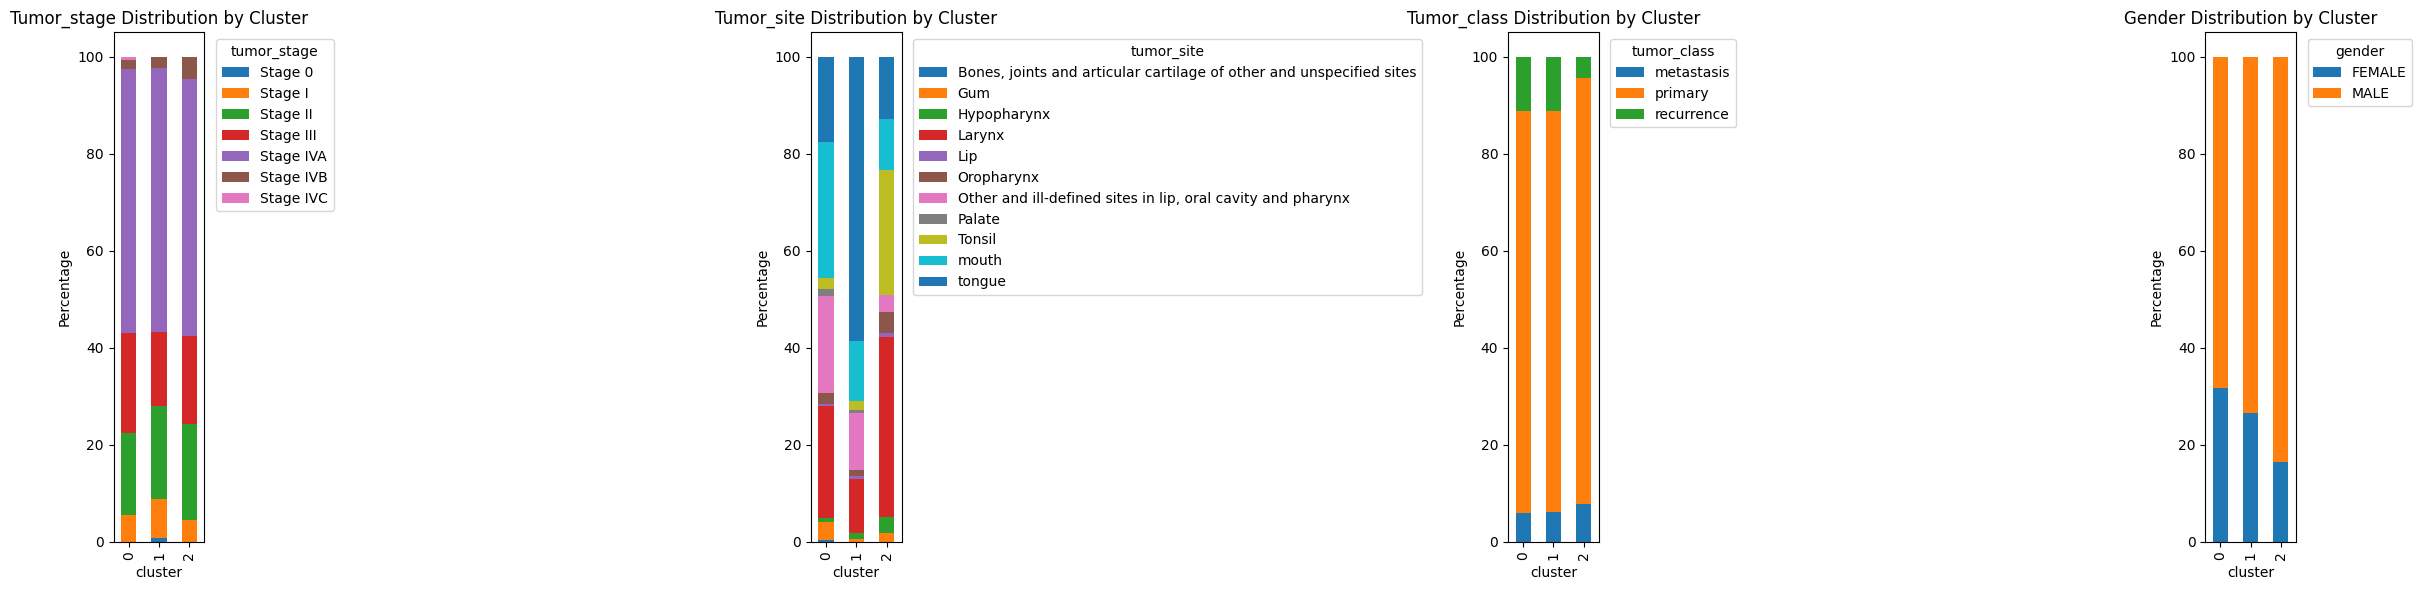

In [54]:
# ============================================================
# Creating Stacked Bar Plots for Each Categorical Variable
# ============================================================
# We will produce one stacked bar plot per variable.
# In each plot the x-axis corresponds to the groups (here: clusters)
# and the bars show the relative percentages of each category for the variable.

variables = ['tumor_stage', 'tumor_site', 'tumor_class','gender']

# Create one subplot per variable
fig, axes = plt.subplots(1, len(variables), figsize=(6 * len(variables), 6))

# Iterate over the variables and plot each as a stacked bar chart
for ax, var in zip(axes, variables):
    # Create a contingency table of cluster vs the current variable.
    # The option normalize='index' computes the proportions within each cluster,
    # and multiplying by 100 converts those to percentages.
    ct = pd.crosstab(df['cluster'], df[var], normalize='index') * 100
    
    # Plot the stacked bar chart.
    ct.plot(kind='bar', stacked=True, ax=ax)
    
    # Set labels and title.
    ax.set_ylabel('Percentage')
    ax.set_title(f'{var.capitalize()} Distribution by Cluster')
    
    # Place the legend outside for better readability.
    ax.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout so the subplots don’t overlap.
plt.tight_layout()
plt.show()


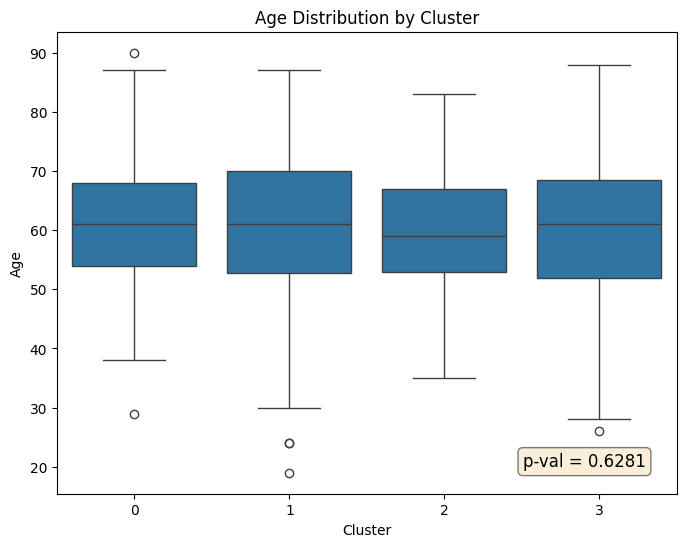

In [29]:
# ============================================================
# Create Boxplot: Age distribution by Cluster
# ============================================================
order = sorted(df['cluster'].unique())

groups = [df[df['cluster'] == cluster]['age'] for cluster in df['cluster'].unique()]
anova_result = stats.f_oneway(*groups)
p_val = anova_result.pvalue

plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster', y='age', data=df, order=order)
plt.title('Age Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')

ax = plt.gca()
ax.text(0.95, 0.05, f"p-val = {p_val:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()
